# BERTのメカニズム
BERTと呼ばれる深層学習モデルで7章と同じIMDbデータセットのポジネガ分析を行う  
  
BERTは2018年後半にGoogleが発表したNLP用深層学習モデル  
BERT=Bidirectional Encoder Representations from Transformers  
これまでのNLPモデルとは一線を画し，ブレークスルーのきっかけとなる期待を持たれている  

## まとめ
BERTの特徴
- BERTの基礎部分に事前学習用アダプターモジュールをつけて学習させる
    - Masked Language Model: 複数単語をマスクして他の単語からそれらを推測
    - Next Sentence Prediction: 2つの文章に関連があるかを推測
    - 学習済みのBERT基礎部分をファインチューニングし，他のタスクに取り組むことができる．
- Attentionをふんだんに使い，単語埋め込みベクトルを文脈を考慮した埋め込みベクトルへ変化させる
- Transformer同様，タスクを解くにあたって入力のどこに着目したのかを可視化・説明できる
- (WordPieceという手法で単語をサブワードに分割して取り扱い，未知語へ強くする)
  
モジュール構成(学習済みパラメータが公開されているのでロードする)  
- `BertForMaskedLM`: BERTの基礎部分＋事前学習タスク用アダプターモジュール
    - `BertModel`: BERTの基礎部分
        - `BertEmbeddings`: 単語を3つの埋め込みベクトルに変換し加算
            - `Token Embedding`: IDから導かれる埋め込みベクトル
            - `Positional Embedding`: 位置に対するベクトル
            - `Sentence Embedding`: 2文を0,1で区分したものに対するベクトル
        - `BertEncoder`: 次のBertLayerを12回繰り返す
            - `BertLayer`: Self-Attentionを中心とするTransformer的なもの
                - `BertAttention`: Self-Attentionを計算
                    - `BertSelfAttention`: Self Attention部分．
                        - multi-head(12個に分割)してSelf-Attentionかけて再度結合
                    - `BertSelfOutput`: `全結合`，`Dropout`, `LayerNorm`
                - `BertIntermediate`: Self-Attentionの出力を全結合層で処理
                    - 入力を4倍に広げる`全結合`
                    - `GELU`: 入力0付近の出力が滑らかな活性化関数を使用
                - `BertOutput`: Attentionとサイズを`全結合`で合わせたIntermediateの出力を加算
                    - `Dropout`, `LayerNorm`も
        - `BertPooler`: BertEncoderの出力から`<cls>`の特徴量を取り出す
            - それを`全結合`層で特徴量変換し，`Tanh`で-1~1の範囲にする
    - `BertPreTrainingHeads`: 事前学習タスク用のアダプターモジュール
        - `MaskedWordPredictions`: 複数個所隠して残りの単語から隠された単語を推論
            - `BertPredictionHeadTransform`: BertModelの出力に`全結合`，`Dropout`，`LayerNorm`
        - `SeqRelationship`: 1文目と2文目に関連性があるかを判定する`全結合`  

## BERTのモデル構造の概要
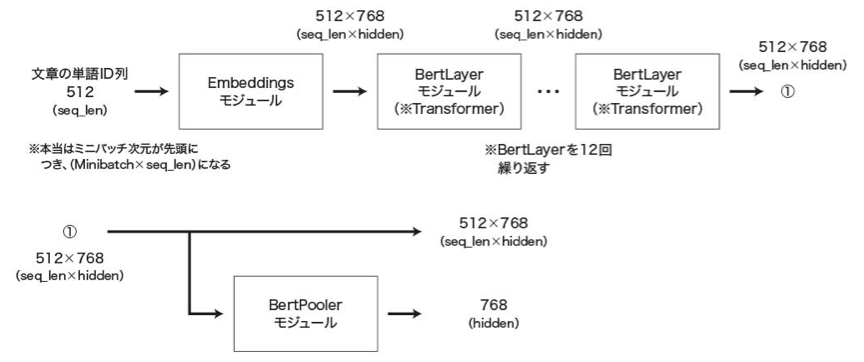

本書では小さい方のBERTであるBERT-Baseを扱う  
  
BERTの構成はTransformerとほぼ同じだが，いくらか違いがある  
- 入力: 512単語に増えている
- Embeddingsモジュール: ID→ベクトルに加え，位置情報の追加(PE)も行う
    - 単語ベクトルの長さは768になっている
- BertLayerモジュール: Transformer, 12回繰り返す
- BertPoolerモジュール: `<cls>`とした先頭単語部分を抜き出す
    - 入力全体の代表となる．クラス分類に使用する．

## BERTが事前学習する2種類の言語タスク
ここまではBERTはただの12段Transformer  
その大きな違いは，BERTはモデルを2種類の言語タスクで事前学習させること  
- Masked Language Model (MLM)
- Next Sentence Prediction (NSP)

MLMはword2vecのCBOWタスクの拡張版  
複数単語をマスクし，残り全ての単語からマスク部分を推定する  
そして，マスクされた単語の特徴量ベクトルを獲得する  
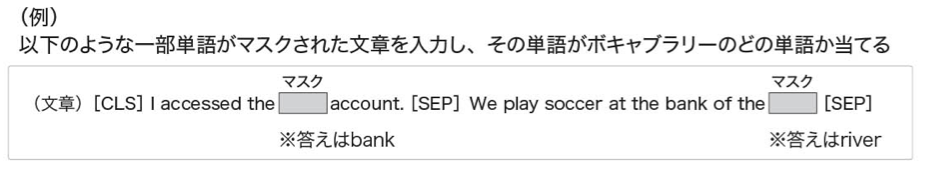

NSPは2つの文が意味的に繋がりがあるかどうかを判定するタスク  
512単語が入力になっていたのは，256単語の文を2つ使うため  
2つの文を`<sep>`で区切り，`<cls>`の特徴量の近さから繋がりの強さを判定  
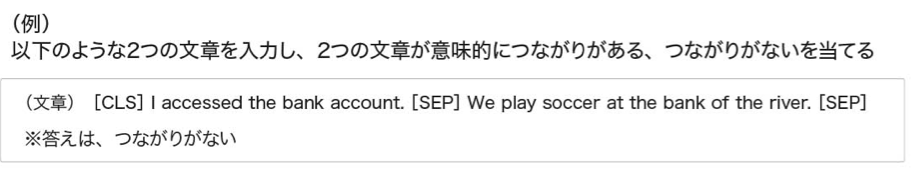

これら2つの言語タスクを解くためのモジュールを繋げたBERTモデルが以下  
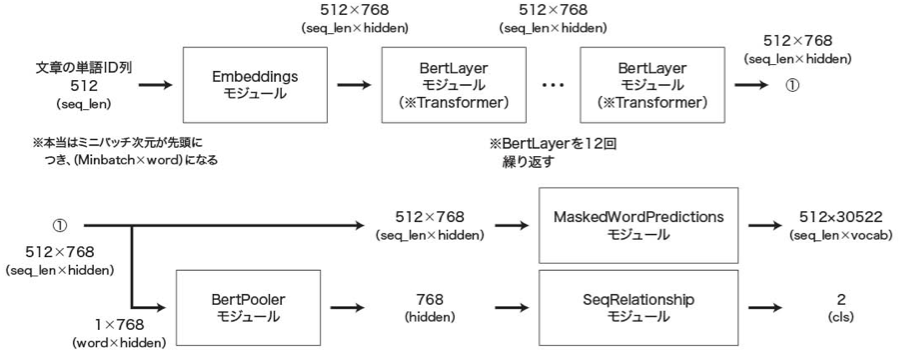

- MaskedWordPredictionsモジュール: MLMを解くモジュール
    - (512, 30522)という出力になっているが，これは単語数×BERTの全語彙数
    - 入力512単語のうち，マスクされている単語が全語彙のどれかを出力
        - IDじゃなくてベクトルにすればいいのでは？
- SeqRelationshipモジュール: NSPを解くモジュール
    - BertPoolerモジュールの出力から，入力の2文の関係の強さを判定

## BERTの3つの特徴を理解する
- 文脈に依存した単語ベクトル表現を作れるようになった
- NLPタスクでファインチューニングが可能になった
- Attentionにより説明性と可視化が簡便

#### 文脈に依存した単語ベクトル表現
例えば，bankには「銀行」と「土手」という意味がある．  
このような同音同名異義語は日本語にも存在する．  
BERTではこのような文脈に応じた単語ベクトルの表現が可能になった  
  
入力地点ではこれら2単語は同じID，同じベクトルである．  
しかし，12段のTransformerを経ると，両者は異なるベクトルになる  
この新しいベクトルを使ってMLMを解くと同じ単語でも周辺の英語との関係性から文脈に応じた単語ベクトルが作成される

#### NLPでのファインチューニング
BERTでは，まず上記2つのタスクを解かせるモジュールで本体を訓練する  
その後，それらのモジュールを，実施したいNLPタスクに合わせた「アダプターモジュール」に取り替え，タスクに応じた出力を得ることができる  
  
例えば，アダプターモジュールはポジネガ感情分析なら，前章で行なったように全結合層を1つ追加して文章の感情判定が可能になる．  
  
このような特徴は，2章のSSDや4章のOpenPoseのVGGのような役割に当たる．  
  
MLMは単語を文脈に応じた特徴量ベクトルに変換する能力  
NSPは文が意味的に繋がっているのかを判定する能力  
大まかに文章全体の意味を理解する力を獲得していると考えられる．  
これらを基盤に，応用的なNLPタスクである感情分析などにも転用できる  
より良い事前学習タスクが出てくる可能性はあるが，この事前学習→応用タスクの流れは1つのスタンダードになっていくであろう．

#### Attentionによる説明性と可視化
7章と基本的に同じ  
Attentionは予測結果に影響した単語をハイライトすることができる．  
これはBERTも同じで，DLモデルの解釈性・説明性に寄与する

# BERTの実装

## 使用するデータ
- IMDbデータセット(7章と同じなのでデータをコピーしておく)
- bert-base-uncased-vocab: BERTで使用するボキャブラリ一覧
- pytorch_model.bin: BERTの学習済みモデルパラメータ

In [1]:
import os, io, glob, shutil
import zipfile, tarfile
import urllib.request

In [2]:
data_dir = "../../datasets/ptca_datasets/chapter8"
imdb_dir = os.path.join(data_dir, "aclImdb")
vocab_dir = os.path.join(data_dir, "vocab")
weights_dir = os.path.join(data_dir, "weights")
    
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

if not os.path.exists(imdb_dir):
    imdb_dir_chapter_7 = data_dir[:-1] + "7/aclImdb"
    shutil.copytree(imdb_dir_chapter_7, imdb_dir)

if not os.path.exists(vocab_dir):
    os.mkdir(vocab_dir)

if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

bert-base-uncased： BERT用ボキャブラリをダウンロード  
Uncasedは小文字化モードという意味です

In [3]:
vocab_save_path=os.path.join(vocab_dir, "bert-base-uncased-vocab.txt")

if not os.path.exists(vocab_save_path):
    vocab_url = "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt"
    urllib.request.urlretrieve(vocab_url, vocab_save_path)

[bert-base-uncased](https://github.com/huggingface/pytorch-pretrained-BERT/): BERTの学習済みモデルをダウンロード  
フォルダ「weights」に「pytorch_model.bin」と「bert_config.json」ができます

In [4]:
weights_save_path = os.path.join(weights_dir, "bert-base-uncased.tar.gz")
config_save_path = os.path.join(weights_dir, "bert_config.json")

if not os.path.exists(config_save_path):
    weights_url = "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz"
    urllib.request.urlretrieve(weights_url, weights_save_path)

    # 解凍
    tar = tarfile.open(weights_save_path, 'r:gz')
    tar.extractall(weights_dir)
    tar.close()
    os.remove(weights_save_path)

# 圧縮ファイルは削除するので，weightsファイルにパスを書き換え
weights_save_path = os.path.join(weights_dir, "pytorch_model.bin")

## BERT_Baseモデル設定ファイルの読み込み
bert_config.json: Transformerが12段であることや特徴量ベクトルが768次元であることなどが記載されている  
attrdictによって属性としてアクセスできるようにする  
``` bash
$ pip install attrdict
```

In [5]:
import json
from attrdict import AttrDict

with open(config_save_path, 'r') as json_file:
    config = json.load(json_file)
    print(config)

config = AttrDict(config)
print(config.hidden_size)

{'attention_probs_dropout_prob': 0.1, 'hidden_act': 'gelu', 'hidden_dropout_prob': 0.1, 'hidden_size': 768, 'initializer_range': 0.02, 'intermediate_size': 3072, 'max_position_embeddings': 512, 'num_attention_heads': 12, 'num_hidden_layers': 12, 'type_vocab_size': 2, 'vocab_size': 30522}
768


## BERT用にLayerNormalization層を定義
PyTorchのLayerNormはTensorflowのものと少し挙動が異なる  
ゼロ除算防止のepsilonの入れ方が違うらしい  
Tensorflowに合わせて作る

In [6]:
import math
import torch
import torch.nn as nn

In [7]:
class BertLayerNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-12):
        super(BertLayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(hidden_size)) # weight
        self.beta = nn.Parameter(torch.zeros(hidden_size)) # bias
        self.variance_epsilon = eps
    
    def forward(self, x):
        # 入力データから 平均を引く->平均0, 分散で割る->分散1
        u = x.mean(-1, keepdim=True)
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.gamma * x + self.beta

## Embeddingsモジュールの実装
Transformerの場合と比べていくつか違う点がある  
  
Positional Encoding(位置情報ベクトル)の表現手法はTransformerではsin, cosだったが，その表現方法もBERTでは学習させる．ただし，単語ベクトルの位置情報のみで，次元情報は与えない  
つまり，各単語の768次元には同じpositional_embeddings値が使われる．  
  
また，2つの文章を区分するEmbeddingであるSentence Embeddingを用意する  
  
今回のEmbeddingsモジュールでは，3つのEmbeddingの結果を足し算する
- Token Embedding: IDを単語ベクトルに変換
- Positional Embedding: 位置情報ベクトル
- Sentence Embedding: 2文を区分
  
入力は次の2つをとる
- input_ids: (batch_size, seq_len), 全単語ID
- token_type_ids: (batch_size, seq_len), 各単語の所属文章ID

In [8]:
class BertEmbeddings(nn.Module):
    def __init__(self, config):
        super(BertEmbeddings, self).__init__()
        
        # EmbeddingLayer: (入力の種類数, 組込ベクトルサイズ)
        # 48とかのIDを受け取ってone-hot vectorと解釈して組込ベクトルへ変換する
        # 重みは後でロードする
        
        self.word_embeddings = nn.Embedding(
            config.vocab_size, # 30522
            config.hidden_size, # 768
            padding_idx=0 # ID=0はpadding扱い
        )
        
        self.position_embeddings = nn.Embedding(
            config.max_position_embeddings, # 512
            config.hidden_size # 768
        )
        
        self.token_type_embeddings = nn.Embedding(
            config.type_vocab_size, # 2
            config.hidden_size # 768
        )
        
        self.LayerNorm = BertLayerNorm(config.hidden_size)
        self.dropout = nn.Dropout(config.hidden_dropout_prob) # 0.1
    
    def forward(self, input_ids, token_type_ids=None):
        # input_ids: (batch_size, seq_len)の文章中の単語ID列
        
        # ID -> 単語ベクトル
        words_embeddings = self.word_embeddings(input_ids)
        
        # position ID -> 位置情報ベクトル
        seq_length = input_ids.size(1) # 512
        position_ids = torch.arange(
            seq_length, dtype=torch.long, device=input_ids.device) # 0~511
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        
        # 文章分割情報 -> 文章分割ベクトル
        # token_type_idsがなければすべてを1文目にする
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)
        
        # 3つの埋め込みベクトルを足し合わせる
        # (batch_size, seq_len, hidden_size)
        embeddings = words_embeddings + position_embeddings + token_type_embeddings
        
        # 埋め込みベクトルを正規化 & Dropout
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        
        return embeddings

## BertLayerモジュール
いわゆるTransformer  
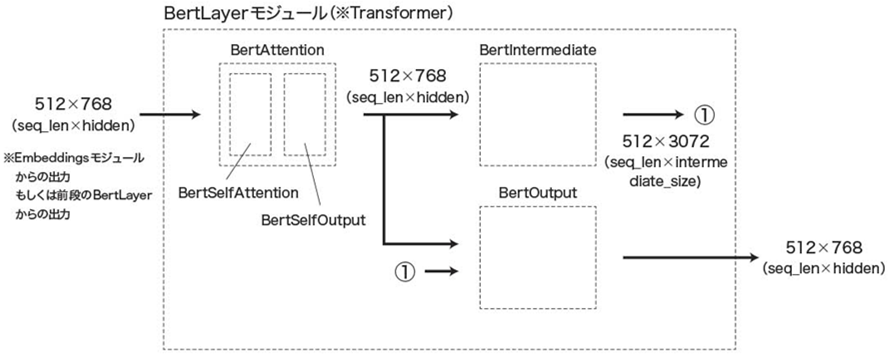
以下のサブネットワークを持つ  
- BertAttention: Self-Attentionを計算
- BertIntermediate: Self-Attentionの出力を全結合層で処理
- BertOutput: BertAttentionとBertIntermediateの出力を足し算


Transformerと異なる点が2つある  
- BertIntermediateの全結合層の活性化関数がGELU
    - Gaussian error Linear Unit
    - 入力0付近の出力が滑らか
- Multi-Head Self-Attention
    - 前章ではSingle-Head Self-Attentionだった
    - 入力を12個に分割し，64次元のAttention×12に入れて出力を結合
    - どんな効果がある？
    
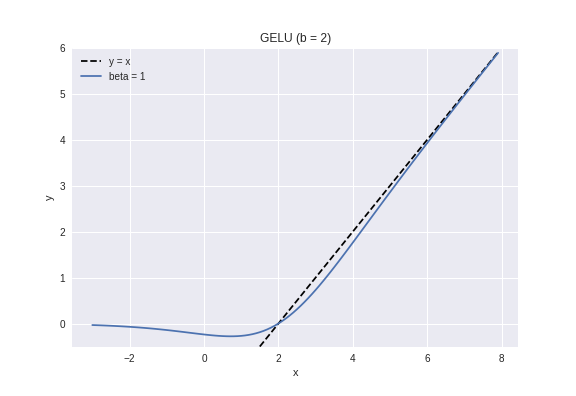  

あと，self-attentionの出力をreturnするかを選択するflgを使用する

#### BertAttentionモジュールの作成
- BertSelfAttention: Self Attention部分．multi-headする
    - attention_prob: attentionのかかり具合(返すか選択できる)
    - context_layer: 入力に対してattentionがかかった結果
- BertSelfOutput: 全結合，Dropout，Normを一発かます．サイズはそのまま

In [9]:
class BertSelfAttention(nn.Module):
    def __init__(self, config):
        super(BertSelfAttention, self).__init__()
        
        self.num_attention_heads = config.num_attention_heads # 12
        self.attention_head_size = int(config.hidden_size / self.num_attention_heads) # 64
        self.all_head_size = self.num_attention_heads * self.attention_head_size # 768
        
        # Self-Attentionの特徴量を作成する全結合層
        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)
        
        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)
    
    def transpose_for_scores(self, x):
        # multi-head attention用にテンソルの形を変換
        # [batch_size, seq_len, hidden] -> [batch_size, 12, seq_len, hidden/12]
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)
    
    def forward(self, hidden_states, attention_mask, attention_show_flg=False):
        
        # 入力を全結合層で特徴量変換(分岐前)
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)
        
        # multi-head Attentionとして分岐
        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)
        
        # 特徴量同士の類似度を求める
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        
        # マスクをかける
        # 足し算なのは，attention_maskに0か-infが入っているため
        # -infはsoftmax正規化したときに0になる
        attention_scores = attention_scores + attention_mask
        
        # AttentionMapの正規化とドロップアウト
        attention_probs = nn.Softmax(dim=-1)(attention_scores)
        attention_probs = self.dropout(attention_probs)
        
        # Attenton Mapをvalueに掛け算
        context_layer = torch.matmul(attention_probs, value_layer)
        
        # multi-head Attentionの出力を結合
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        
        if attention_show_flg:
            return context_layer, attention_probs
        else:
            return context_layer

In [10]:
class BertSelfOutput(nn.Module):
    def __init__(self, config):
        super(BertSelfOutput, self).__init__()
        
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = BertLayerNorm(config.hidden_size)
        self.dropout = nn.Dropout(config.hidden_dropout_prob) # 0.1
    
    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states

In [11]:
class BertAttention(nn.Module):
    def __init__(self, config):
        super(BertAttention, self).__init__()
        self.selfattn = BertSelfAttention(config)
        self.output = BertSelfOutput(config)
    
    def forward(self, input_tensor, attention_mask, attention_show_flg = False):
        
        if attention_show_flg:
            self_output, attention_probs = self.selfattn(input_tensor, attention_mask, attention_show_flg)
            attention_output = self.output(self_output, input_tensor)
            return attention_output, attention_probs
        
        else:
            self_output = self.selfattn(input_tensor, attention_mask, attention_show_flg)
            attention_output = self.output(self_output, input_tensor)
            return attention_output

#### BertIntermediateモジュールの作成
- BertIntermediate: 入力を4倍に広げる全結合とgelu

In [12]:
def gelu(x):
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

In [13]:
class BertIntermediate(nn.Module):
    def __init__(self, config):
        super(BertIntermediate, self).__init__()
        
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        self.intermediate_act_fn = gelu
    
    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states

BertOutputモジュールの作成
- BertOutput: 広げた全結合を全結合で元に戻してDropout, SelfAttentionの出力と加算

In [14]:
class BertOutput(nn.Module):
    def __init__(self, config):
        super(BertOutput, self).__init__()
        
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(config.hidden_dropout_prob) # 0.1
    
    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states

#### BertLayerモジュールの作成
- BertAttention
- BertIntermediate
- BertOutput

Embedderから入力をもらう  
これまで作ったモジュールで，  
BertOutput(BertAttention + Linear(BertIntermediate(BertAttention)))  
する

In [15]:
class BertLayer(nn.Module):
    def __init__(self, config):
        super(BertLayer, self).__init__()
        
        self.attention = BertAttention(config)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)
    
    def forward(self, hidden_states, attention_mask, attention_show_flg=False):
        # hidden_states: Embedderモジュールの出力 (batch_size, seq_len, hidden_size)
        # attention_mask: マスク
        
        if attention_show_flg:
            attention_output, attention_probs = self.attention(
                hidden_states, attention_mask, attention_show_flg)
            intermediate_output = self.intermediate(attention_output)
            layer_output = self.output(intermediate_output, attention_output)
            return layer_output, attention_probs
        
        else:
            attention_output = self.attention(
                hidden_states, attention_mask, attention_show_flg)
            intermediate_output = self.intermediate(attention_output)
            layer_output = self.output(intermediate_output, attention_output)
            return layer_output

## BertEncoder: BertLayerモジュールの繰り返し部分
BertLayer12個を順伝搬  
12段分すべての出力を返すか，最終段のみ返すか選べる  
12段分すべて見ることで各層で注意がかかっているところの変化をみられる  
12個のSelf-Attentionを出力するかも選べる

In [16]:
class BertEncoder(nn.Module):
    def __init__(self, config):
        super(BertEncoder, self).__init__()
        module_list = [BertLayer(config) for _ in range(config.num_hidden_layers)]
        self.layer = nn.ModuleList(module_list)
    
    def forward(self, hidden_states, attention_mask, 
                output_all_encoded_layers=True, attention_show_flg=False):
        
        all_encoder_layers = []
        
        # BertLayerの繰り返し
        for layer_module in self.layer:
            
            if attention_show_flg:
                hidden_states, attention_probs = layer_module(
                    hidden_states, attention_mask, attention_show_flg)
            else:
                hidden_states = layer_module(
                    hidden_states, attention_mask, attention_show_flg)
            
            # 12段すべての出力を見る場合
            if output_all_encoded_layers:
                all_encoder_layers.append(hidden_states)
                
        # 最終段のAttentionのみ必要な場合
        if not output_all_encoded_layers:
            all_encoder_layers.append(hidden_states)
        
        if attention_show_flg:
            return all_encoder_layers, attention_probs
        else:
            return all_encoder_layers

## BertPoolerモジュール

BertEncoderの出力から1単語目`<cls>`の部分の特徴量テンソルを取り出す  
それを全結合層で特徴量変換し，Tanhで-1~1の範囲にする  

In [17]:
class BertPooler(nn.Module):
    def __init__(self, config):
        super(BertPooler, self).__init__()
        
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()
    
    def forward(self, hidden_states):
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output

## 動作確認
- ミニバッチサイズ: 2
- 文章の長さ: 5
    - 2文章が1つの文章に入っている
    - マスクも適当に作成する
- Multi-Head Attention用のextended_attention_maskを作成
- Attentionに対するマスクは-10000と大きな負の値でSigmoid後をほぼ0にする値を使う

In [18]:
# 単語のID列，Batch Sizeは2
input_ids = torch.LongTensor([[31, 51, 12, 23, 99], [15, 5, 1, 0, 0]])
print("Input Size:", input_ids.shape)

# Attentionに対するマスク
attention_mask = torch.LongTensor([[1, 1, 1, 1, 1], [1, 1, 1, 0, 0]])
print("Input Mask Size:", attention_mask.shape)

# 文章ID　0が1文目，1が2文目を示す
token_type_ids = torch.LongTensor([[0, 0, 1, 1, 1], [0, 1, 1, 1, 1]])
print("Input ID Tensor Size:", token_type_ids.shape)

# BERTの各モジュールを用意
embeddings = BertEmbeddings(config)
encoder = BertEncoder(config)
pooler = BertPooler(config)

# マスクを(batch, 1, 1, seq_len=5)にする
extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2) # multi-headに次元を対応
extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0 # 値を0か-10000にする
extended_attention_mask = extended_attention_mask.to(dtype=torch.float32)
print("Extended Attention Mask Size:", extended_attention_mask.shape)

# 順伝搬
out1 = embeddings(input_ids, token_type_ids)
out2 = encoder(out1, extended_attention_mask)
out3 = pooler(out2[-1])

print("BertEmbeddings Size:", out1.shape)
print("Encoder (Last Attention) Size:", out2[-1].shape)
print("BertPooler Size:", out3.shape)

Input Size: torch.Size([2, 5])
Input Mask Size: torch.Size([2, 5])
Input ID Tensor Size: torch.Size([2, 5])
Extended Attention Mask Size: torch.Size([2, 1, 1, 5])
BertEmbeddings Size: torch.Size([2, 5, 768])
Encoder (Last Attention) Size: torch.Size([2, 5, 768])
BertPooler Size: torch.Size([2, 768])


## 全部繋げてBERTモデルにする
今の動作確認みたいなことをモジュールにまとめる

In [19]:
class BertModel(nn.Module):
    def __init__(self, config):
        super(BertModel, self).__init__()
        
        self.embeddings = BertEmbeddings(config)
        self.encoder = BertEncoder(config)
        self.pooler = BertPooler(config)
    
    def extend_attention_mask(self, attention_mask):
        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
        extended_attention_mask = extended_attention_mask.to(dtype=torch.float32)
        extended_attention_mask = (1.0 - extended_attention_mask * -10000.0)
        return extended_attention_mask
    
    def forward(self, input_ids, token_type_ids=None, attention_mask=None,
               output_all_encoded_layers=True, attention_show_flg=False):
        
        # Noneなら全てマスクしない
        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids)
        
        # Noneなら全て1文目
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)
        
        # Multi-Head Attention対応(次元増加，足し算でのマスク)
        extended_attention_mask = self.extend_attention_mask(attention_mask)
        
        # 順伝搬させる
        embedding_output = self.embeddings(input_ids, token_type_ids)
        
        if attention_show_flg:
            encoded_layers, attention_probs = self.encoder(
                embedding_output,
                extended_attention_mask,
                output_all_encoded_layers,
                attention_show_flg
            )
        else:
            encoded_layers = self.encoder(
                embedding_output,
                extended_attention_mask,
                output_all_encoded_layers,
                attention_show_flg
            )
        
        pooled_output = self.pooler(encoded_layers[-1])
        
        if not output_all_encoded_layers:
            encoded_layers = encoded_layers[-1]
        
        if attention_show_flg:
            return encoded_layers, pooled_output, attention_probs
        else:
            return encoded_layers, pooled_output

動作確認

In [20]:
net = BertModel(config)
encoded_layers, pooled_output, attention_probs = net(
    input_ids, token_type_ids, attention_mask,
    output_all_encoded_layers=False,
    attention_show_flg=True
)

print("Encoded Layers (Last Attention) Size:", encoded_layers.shape)
print("Pooled Output Size:", pooled_output.shape)
print("Attention Probs Size:", attention_probs.shape)

Encoded Layers (Last Attention) Size: torch.Size([2, 5, 768])
Pooled Output Size: torch.Size([2, 768])
Attention Probs Size: torch.Size([2, 12, 5, 5])


以上，BERTモデルの実装を行った

# BERTを用いたベクトル表現の比較
bank, 銀行vs土手  

## 学習済みモデルのロード
pytorch_model.binのものとパラメータ名が異なる  
しかし，順番は同じなので前から順番にパラメータをコピー＆ロードしていく

In [21]:
loaded_state_dict = torch.load(weights_save_path)
print("parameters number:", len(loaded_state_dict.keys()))
for s in list(loaded_state_dict.keys())[:5]:
    print(s)
print("...")

parameters number: 207
bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.gamma
bert.embeddings.LayerNorm.beta
...


実装したBERTモデルのパラメータ名も確認してみる

In [22]:
net = BertModel(config)
net.eval()
print("parameters number:", len(list(net.named_parameters())))
for s, param in list(net.named_parameters())[:5]:
    print(s)
print("...")

parameters number: 199
embeddings.word_embeddings.weight
embeddings.position_embeddings.weight
embeddings.token_type_embeddings.weight
embeddings.LayerNorm.gamma
embeddings.LayerNorm.beta
...


パラメータ数が違うのは，cls.predictions.biasなど，事前学習タスク用のclsモジュールのパラメータが含まれているかの違い  
  
前から順番にパラメータの中身をコピーし，おかしなコピーがないかチェックしながらロードする

In [25]:
new_state_dict = net.state_dict().copy()
param_names = [name for name, param in list(net.named_parameters())]
param_len = len(param_names)

for i, (key_name, value) in enumerate(loaded_state_dict.items()):
    name = param_names[i]
    new_state_dict[name] = value
    # print(str(key_name), "->", str(name))
    if i+1 >= param_len: break

net.load_state_dict(new_state_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## BERT用のTokenizerの実装
スペースではなく，サブワードの概念で単語を分割する  
詳細には触れないが，WordPieceという手法を使用している  
bert-base-uncased-vocab.txtは1行に1サブワードが記載されている  
vocab: word->id, ids_to_tokens: id->wordをこのファイルから作成

In [30]:
import collections

def load_vocab(vocab_file_path):
    vocab = collections.OrderedDict()
    ids_to_tokens = collections.OrderedDict()
    
    with open(vocab_file_path, "r", encoding="utf-8") as f:
        for index, token in enumerate(f.readlines()):
            token = token.strip()
            vocab[token] = index
            ids_to_tokens[index] = token
    
    return vocab, ids_to_tokens

vocab, ids_to_tokens = load_vocab(vocab_save_path)
len(vocab), len(ids_to_tokens)

(30522, 30522)

この時点では，ほとんどが`<unused??>`で，`<cls>`や`<pad>`などが入っている   
次の単語分割で実際の単語を入れていく  
sub-word単語分割に使うTokenizerの実装は結構ガチなので，用意されているものを使う

In [38]:
from utils.tokenizer import BasicTokenizer, WordpieceTokenizer

class BertTokenizer():
    def __init__(self, vocab_file_path, do_lower_case=True):
        
        self.vocab, self.ids_to_tokens = load_vocab(vocab_file_path)
        never_split = ("[UNK]", "[SEP]", "[PAD]", "[CLS]", "[MASK]")
        
        self.basic_tokenizer = BasicTokenizer(
            do_lower_case=do_lower_case,
            never_split=never_split
        )
        
        self.wordpiece_tokenizer = WordpieceTokenizer(vocab=self.vocab)
    
    def tokenize(self, text):
        split_tokens = []
        
        for token in self.basic_tokenizer.tokenize(text):
            for sub_token in self.wordpiece_tokenizer.tokenize(token):
                split_tokens.append(sub_token)
        
        return split_tokens
    
    def convert_tokens_to_ids(self, tokens):
        return [self.vocab[token] for token in tokens]
    
    def convert_ids_to_tokens(self, ids):
        return [self.ids_to_tokens[i] for i in ids]

## 文脈による意味変化
Bankの文脈による意味変化を単語ベクトルとして求める  
そして1段目か12段目のAttentionの出力の類似度を比較することで確認する  
以下の文章から，銀行と土手の意味を捉えられるのかを確認する  
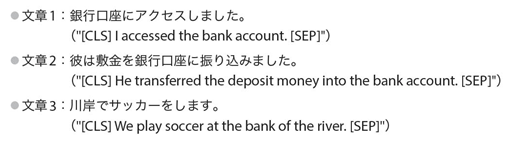

In [36]:
text_1 = "[CLS] I accessed the bank account. [SEP]"
text_2 = "[CLS] He transferred the deposit money into the bank account. [SEP]"
text_3 = "[CLS] We play soccer at the bank of the river. [SEP]"

単語分割

In [39]:
tokenizer = BertTokenizer(vocab_save_path)

tokenized_text_1 = tokenizer.tokenize(text_1)
tokenized_text_2 = tokenizer.tokenize(text_2)
tokenized_text_3 = tokenizer.tokenize(text_3)

print(tokenized_text_1)
print(tokenized_text_2)
print(tokenized_text_3)

['[CLS]', 'i', 'accessed', 'the', 'bank', 'account', '.', '[SEP]']
['[CLS]', 'he', 'transferred', 'the', 'deposit', 'money', 'into', 'the', 'bank', 'account', '.', '[SEP]']
['[CLS]', 'we', 'play', 'soccer', 'at', 'the', 'bank', 'of', 'the', 'river', '.', '[SEP]']


単語をIDに変換

In [41]:
import numpy as np

indexed_tokens_1 = tokenizer.convert_tokens_to_ids(tokenized_text_1)
indexed_tokens_2 = tokenizer.convert_tokens_to_ids(tokenized_text_2)
indexed_tokens_3 = tokenizer.convert_tokens_to_ids(tokenized_text_3)

bank_posi_1 = np.where(np.array(tokenized_text_1) == "bank")[0][0] # 4
bank_posi_2 = np.where(np.array(tokenized_text_2) == "bank")[0][0] # 8
bank_posi_3 = np.where(np.array(tokenized_text_3) == "bank")[0][0] # 6

tokens_tensor_1 = torch.tensor([indexed_tokens_1])
tokens_tensor_2 = torch.tensor([indexed_tokens_2])
tokens_tensor_3 = torch.tensor([indexed_tokens_3])

# bankの単語ID
bank_word_id = tokenizer.convert_tokens_to_ids(["bank"])[0]

print(tokens_tensor_1)

tensor([[  101,  1045, 11570,  1996,  2924,  4070,  1012,   102]])


BERTで推論

In [42]:
with torch.no_grad():
    encoded_layers_1, _ = net(tokens_tensor_1, output_all_encoded_layers=True)
    encoded_layers_2, _ = net(tokens_tensor_2, output_all_encoded_layers=True)
    encoded_layers_3, _ = net(tokens_tensor_3, output_all_encoded_layers=True)

各文章の1段目と12段目のbankの位置の特徴量ベクトルを取り出す

In [44]:
# 3文共通のbankの組み込みベクトルを取得
bank_vector_0 = net.embeddings.word_embeddings.weight[bank_word_id]

bank_vector_1_1 = encoded_layers_1[0][0, bank_posi_1]
bank_vector_1_12 = encoded_layers_1[-1][0, bank_posi_1]

bank_vector_2_1 = encoded_layers_2[0][0, bank_posi_2]
bank_vector_2_12 = encoded_layers_2[-1][0, bank_posi_2]

bank_vector_3_1 = encoded_layers_3[0][0, bank_posi_3]
bank_vector_3_12 = encoded_layers_3[-1][0, bank_posi_3]

取り出した単語ベクトルについてコサイン類似度を計算

In [51]:
from torch.nn.functional import cosine_similarity as cos

def compare(vec1, vec2):
    return round(cos(vec1, vec2, dim=0).item(), 3)

print("文脈弱(Bert1) -> 文脈強(Bert12)")
print("bank : bank_1_1 ->", compare(bank_vector_0, bank_vector_1_1))
print("bank : bank_1_12 ->", compare(bank_vector_0, bank_vector_1_12))

print("文脈弱のときの他のbankとの比較")
print("bank_1_1 : bank_2_1 ->", compare(bank_vector_1_1, bank_vector_2_1))
print("bank_1_1 : bank_3_1 ->", compare(bank_vector_1_1, bank_vector_3_1))

print("文脈強の時の他のbankとの比較")
print("bank_1_12 : bank_2_12 ->", compare(bank_vector_1_12, bank_vector_2_12))
print("bank_1_12 : bank_3_12 ->", compare(bank_vector_1_12, bank_vector_3_12))

文脈弱(Bert1) -> 文脈強(Bert12)
bank : bank_1_1 -> 0.681
bank : bank_1_12 -> 0.228
文脈弱のときの他のbankとの比較
bank_1_1 : bank_2_1 -> 0.897
bank_1_1 : bank_3_1 -> 0.758
文脈強の時の他のbankとの比較
bank_1_12 : bank_2_12 -> 0.88
bank_1_12 : bank_3_12 -> 0.481


これらの値から，文脈をまだ読んでいない前半ではほぼ同じ単語だと認識されているが，文脈を読んだ後半では異なる単語だと認識されている．  
よって，BERTがbankの意味を文脈から読み取り，単語ベクトルを再構成する役割を持っていることが分かる

## 事前学習タスク用のモジュールを実装
BertForMaskedLM
- BertModel: 上記で作成したBERTの基礎部分になるモデル
- BertPreTrainingHeads: 事前学習タスク用のアダプターモジュール
    - MaskedWordPredictionsモジュール
        - 複数個所隠して残りの単語から隠された単語を推論
        - BertPredictionHeadTransformモジュール
            - BERT-baseの出力に全結合をかませる
    - SeqRelationshipモジュール
        - 1文目と2文目に関連性があるかを判定する

### MaskedWordPredictionsモジュール

In [76]:
class BertPredictionHeadTransform(nn.Module):
    ''' BERT-baseの出力に全結合をかませる（入出力のサイズは同じ）'''
    def __init__(self, config):
        super(BertPredictionHeadTransform, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size) # 'hidden_size': 768
        self.transform_act_fn = gelu
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=1e-12)

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.transform_act_fn(hidden_states)
        hidden_states = self.LayerNorm(hidden_states)
        return hidden_states


class MaskedWordPredictions(nn.Module):
    def __init__(self, config):
        super(MaskedWordPredictions, self).__init__()
        self.transform = BertPredictionHeadTransform(config)
        self.decoder = nn.Linear(in_features=config.hidden_size,  # 'hidden_size': 768
                                 out_features=config.vocab_size,  # 'vocab_size': 30522
                                 bias=False)
        self.bias = nn.Parameter(torch.zeros(config.vocab_size))  # 'vocab_size': 30522

    def forward(self, hidden_states):
        hidden_states = self.transform(hidden_states)
        hidden_states = self.decoder(hidden_states) + self.bias 
        return hidden_states # (batch, seq_len, vocab_size)

### SeqRelationshipモジュール
先頭単語の特徴量から1文目と2文目に関連性があるかを判定するクラス分類のための全結合層

In [77]:
class SeqRelationship(nn.Module):
    def __init__(self, config, out_features=2):
        super(SeqRelationship, self).__init__()
        self.seq_relationship = nn.Linear(config.hidden_size, out_features)

    def forward(self, pooled_output):
        return self.seq_relationship(pooled_output) # (batch, 2)

### BertPreTrainingHeadsモジュール
事前学習タスクを行うアダプターモジュール  
Bert-baseの2つの出力を受け取る

In [78]:
class BertPreTrainingHeads(nn.Module):
    def __init__(self, config):
        super(BertPreTrainingHeads, self).__init__()
        self.predictions = MaskedWordPredictions(config) # MLM
        self.seq_relationship = SeqRelationship(config) # NSP

    def forward(self, sequence_output, pooled_output):
        prediction_scores = self.predictions(sequence_output) # (batch, seq_len, hidden_size)
        seq_relationship_score = self.seq_relationship(pooled_output) # (batch, 2)
        return prediction_scores, seq_relationship_score

### BertForMaskedLM
BERT-base + アダプターモジュール

In [79]:
class BertForMaskedLM(nn.Module):
    def __init__(self, config, net_bert):
        super(BertForMaskedLM, self).__init__()
        self.bert = net_bert
        self.cls = BertPreTrainingHeads(config)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None):
        encoded_layers, pooled_output = self.bert(
            input_ids, token_type_ids, attention_mask, 
            output_all_encoded_layers=False, attention_show_flg=False
        )
        prediction_scores, seq_relationship_score = self.cls(
            encoded_layers, pooled_output
        )
        return prediction_scores, seq_relationship_score

## 事前学習タスクの推論をさせてみる

学習済みパラメータをロードし，モデルを準備

In [80]:
net_bert = BertModel(config) # BERT-base
net_bert.eval()
net = BertForMaskedLM(config, net_bert) # BERT-base + 事前学習タスク
net.eval()

# 以下，上記のパラメータロードと同様
loaded_state_dict = torch.load(weights_save_path)
new_state_dict = net.state_dict().copy()
param_names = [name for name, param in list(net.named_parameters())]
param_len = len(param_names)

for i, (key_name, value) in enumerate(loaded_state_dict.items()):
    name = param_names[i]
    new_state_dict[name] = value
    if i+1 >= param_len: break

net.load_state_dict(new_state_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

お題はこの2文

In [81]:
text = "[CLS] I accessed the bank account. [SEP] We play soccer at the bank of the river. [SEP]"
tokenized_text = tokenizer.tokenize(text)
print(tokenized_text)

['[CLS]', 'i', 'accessed', 'the', 'bank', 'account', '.', '[SEP]', 'we', 'play', 'soccer', 'at', 'the', 'bank', 'of', 'the', 'river', '.', '[SEP]']


### Masked Language Model (MLM)
複数の単語をマスクしてその周囲の単語からマスクされた単語を推論する問題  
index=13のbankを隠して予測させてみる

In [82]:
masked_index = 13
tokenized_text[masked_index] = '[MASK]' # 隠す
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

print(tokenized_text)
print(indexed_tokens)

['[CLS]', 'i', 'accessed', 'the', 'bank', 'account', '.', '[SEP]', 'we', 'play', 'soccer', 'at', 'the', '[MASK]', 'of', 'the', 'river', '.', '[SEP]']
[101, 1045, 11570, 1996, 2924, 4070, 1012, 102, 2057, 2377, 4715, 2012, 1996, 103, 1997, 1996, 2314, 1012, 102]


1文目に0，2文目に1を入れた文章IDを用意

In [83]:
def seq2id(indexed_tokens):
    ''' 分かち書きされた単語ID列を文章IDに。[SEP]=102で分ける '''
    sep_pos = np.where(np.array(indexed_tokens) == 102)[0]
    sep_pos = sep_pos[0]+1 if len(sep_pos) > 1 else None
    segments_ids = np.zeros(len(indexed_tokens), dtype=int)
    segments_ids[sep_pos:] = 1
    return list(segments_ids)

segments_ids = seq2id(indexed_tokens)
print(segments_ids)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


モデルで推論

In [84]:
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

with torch.no_grad():
    prediction_scores, seq_relationship_score = net(tokens_tensor, segments_tensors)

推論したIDを単語に戻す

In [85]:
predicted_index = torch.argmax(prediction_scores[0, masked_index]).item()
predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]
print(predicted_token)

bank


MASKされた箇所の単語を推論できた

### Next Sentence Prediction (NSP)
[関連のある文章である確率，関連のない文章である確率]  
答えは無関係

In [86]:
print(seq_relationship_score)
print(torch.sigmoid(seq_relationship_score))

tensor([[-1.5349,  3.1653]])
tensor([[0.1773, 0.9595]])


無関係であることを推論できた

## まとめ
BERT及びBERTをベースにした事前学習タスク用のモデルを実装し，動作を確認した  
次章でも以上のBERTは利用する  
utilsに持っていくのがめんどくさいのでmasterからもらってきちゃおっと